In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Define paths in Google Drive
train_path = '/content/drive/MyDrive/ikan/ikan/train'
valid_path = '/content/drive/MyDrive/ikan/ikan/valid'
test_path = '/content/drive/MyDrive/ikan/ikan/test'

In [13]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create data generators without augmentation for the validation and test sets
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 312 images belonging to 5 classes.
Found 48 images belonging to 5 classes.
Found 52 images belonging to 5 classes.


In [15]:
# Load pre-trained DenseNet201 model with pre-trained weights
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a few additional layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

# Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               983552    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [18]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_generator)
print(f"Test Accuracy: {eval_result[1]*100:.2f}%")

Epoch 1/100
10/10 [==============================] - 8s 769ms/step - loss: 0.0281 - accuracy: 0.9904 - val_loss: 1.3922 - val_accuracy: 0.7708
Epoch 2/100
10/10 [==============================] - 6s 604ms/step - loss: 0.0432 - accuracy: 0.9840 - val_loss: 1.6295 - val_accuracy: 0.7500
Epoch 3/100
10/10 [==============================] - 8s 790ms/step - loss: 0.0632 - accuracy: 0.9840 - val_loss: 1.4949 - val_accuracy: 0.7500
Epoch 4/100
10/10 [==============================] - 6s 616ms/step - loss: 0.0216 - accuracy: 0.9968 - val_loss: 1.3711 - val_accuracy: 0.7917
Epoch 5/100
10/10 [==============================] - 8s 779ms/step - loss: 0.0344 - accuracy: 0.9904 - val_loss: 1.0821 - val_accuracy: 0.8333
Epoch 6/100
10/10 [==============================] - 6s 608ms/step - loss: 0.0692 - accuracy: 0.9904 - val_loss: 1.2153 - val_accuracy: 0.8333
Epoch 7/100
10/10 [==============================] - 8s 774ms/step - loss: 0.1020 - accuracy: 0.9744 - val_loss: 1.0883 - val_accuracy: 0.8958

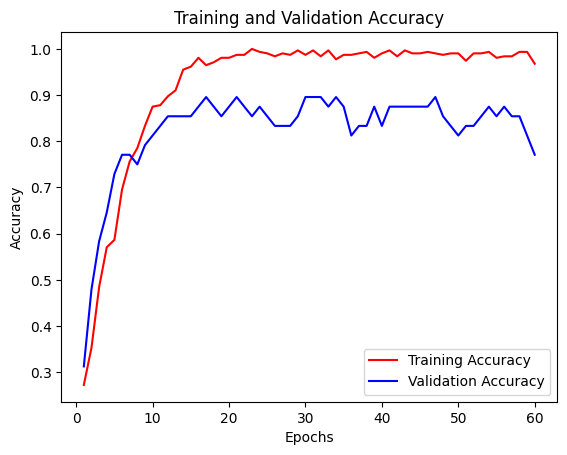

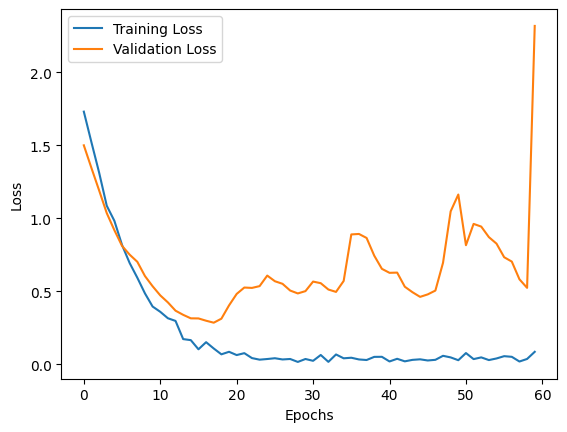

In [17]:
import matplotlib.pyplot as plt
# Plot Loss
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Save the model to an .h5 file
model.save('/content/drive/MyDrive/ikan/ikan/fish_disease_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

load_model = tf.keras.models.load_model('/content/drive/MyDrive/ikan/ikan/fish_disease_model.h5')
def predict_and_display(image_path, load_model, class_labels):
    # Load and process the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict the class probabilities
    predictions = load_model.predict(img_array)

    # Get the predicted class label
    predicted_class = np.argmax(predictions)

    # Display the prediction
    print(f"Predicted Class: {class_labels[predicted_class]}")
    plt.imshow(img)
    plt.show()



1/1 [==============================] - 0s 36ms/step
Predicted Class: Healthy Fish


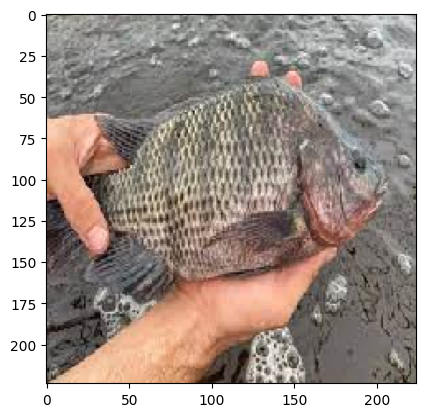

In [34]:
# Test the function with a sample image
class_labels = {
    0: 'Bacterial Gill Disease',
    1: 'Cotton Wool',
    2: 'Fin Root',
    3: 'Healthy Fish',
    4: 'White Spot'
}
sample_image_path = '/content/drive/MyDrive/ikan/predict/s.jpeg'
predict_and_display(sample_image_path, load_model, class_labels)